In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import shapely.wkt
import shapely.geometry
import pandas as pd
import shapely.geometry.multipolygon as sh

In [2]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


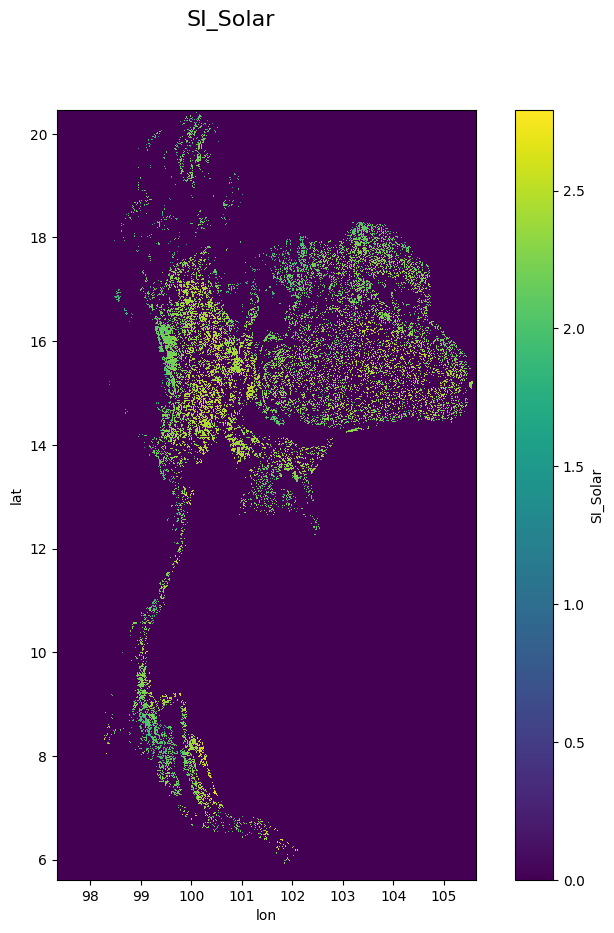

In [3]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_final_SI.nc')
fig, ax = plt.subplots(figsize=(10,10))
type = 'SI_Solar'
fig.suptitle(str(type), fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_landuse_suitability_index[type].plot(ax = ax,zorder = 1)

In [4]:
province = "Kalasin"
province_th = thailandmap.loc[thailandmap['ADM1_EN'] == province]
min_lon = province_th.unary_union.bounds[0]
max_lon = province_th.unary_union.bounds[2]
max_lat = province_th.unary_union.bounds[1]
min_lat = province_th.unary_union.bounds[3]

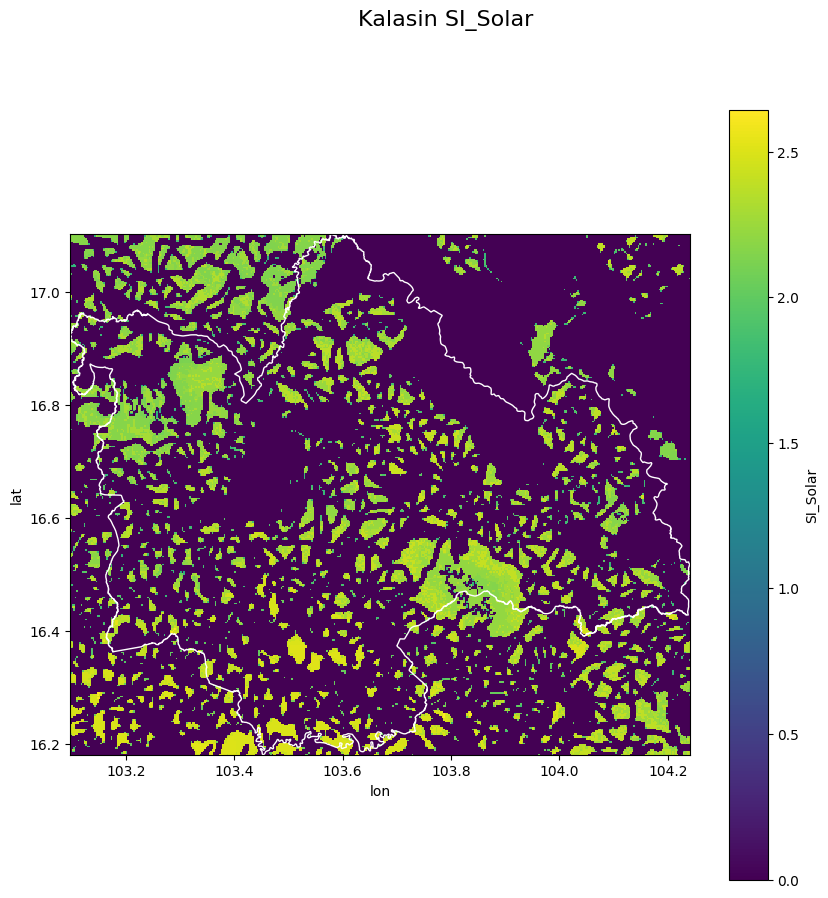

In [5]:
xr_landuse_suitability_index_area = xr_landuse_suitability_index.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province +' '+ str(type), fontsize=16)
province_th.plot(ax = ax, color='none', edgecolor = 'white', zorder = 1)
xr_landuse_suitability_index_area[type].plot(ax = ax,zorder = 0)